In [39]:
using LinearAlgebra
using BenchmarkTools
using Profile
using ProfileView

include("../VidalTEBD.jl")
using .VidalTEBD

In [30]:
function onegate1(U,G,d,D)
    R = PermutedDimsArray(reshape(G,D^2,d),(2,1))
    U*R
end

function onegate2(U,G,d,D)
    R = permutedims(reshape(G,D^2,d),(2,1))
    U*R
end

function onegate3(U,G,d,D)
    R = copy(PermutedDimsArray(reshape(G,D^2,d),(2,1)))
    U*R
end

onegate4 (generic function with 1 method)

### it's faster to copy because multiplication is the bottleneck

In [34]:
D = 1000
d = 2
U = rand(d,d)
G = rand(D,D,d)
@btime onegate1(U,G,d,D)
@btime onegate2(U,G,d,D)
@btime onegate3(U,G,d,D)

  54.778 ms (14 allocations: 15.26 MiB)
  35.257 ms (6 allocations: 30.52 MiB)
  39.009 ms (10 allocations: 30.52 MiB)


2×1000000 Array{Float64,2}:
 0.531023  0.193885  0.948357  0.767474  …  0.275081  0.612013  0.25285 
 0.238988  0.126929  0.512272  0.437693     0.22541   0.305722  0.204458

In [11]:
function twogate1(U,T,d,D)
    R = reshape(PermutedDimsArray(T,(2,4,1,3)),d^2,D^2)
    U*R
end

function twogate2(U,T,d,D)
    R = reshape(permutedims(T,(2,4,1,3)),d^2,D^2)
    U*R
end

function twogate3(U,T,d,D)
    R = copy(reshape(PermutedDimsArray(T,(2,4,1,3)),d^2,D^2))
    U*R
end

twogate3 (generic function with 1 method)

In [13]:
D = 300
d = 2
U = rand(d^2,d^2)
T = rand(D,d,D,d)
@btime twogate1(U,T,d,D)
@btime twogate2(U,T,d,D)
@btime twogate3(U,T,d,D)

  16.577 ms (20 allocations: 2.75 MiB)
  7.132 ms (11 allocations: 5.49 MiB)
  14.154 ms (16 allocations: 5.49 MiB)


4×90000 Array{Float64,2}:
 0.422964  1.10361  0.967987  0.912702  …  0.788813  1.0479    0.926339
 0.33091   1.24203  0.78064   0.862831     0.945222  0.812476  0.867811
 0.570354  1.7124   1.73151   1.31464      1.19878   1.49636   1.21913 
 0.54693   1.20346  1.2751    1.04109      0.798148  1.31784   1.0331  

In [22]:
function naive_contract1(A,B)
    #what happens if it does not need to figure out which indices to contract?
    A2 = reshape(permutedims(A,(2,3,1)),d*D,D)
    B2 = reshape(permutedims(A,(1,2,3)),D,d*D)
    reshape(A2*B2,D,d,D,d)
end

function naive_contract2(A,B)
    #what happens if it does not need to figure out which indices to contract?
    #change naive_contract1 to use PermutedDimsArray
    A2 = reshape(PermutedDimsArray(A,(2,3,1)),d*D,D)
    B2 = reshape(PermutedDimsArray(A,(1,2,3)),D,d*D)
    reshape(A2*B2,D,d,D,d)
end

function naive_contract3(A,B)
    #what happens if it does not need to figure out which indices to contract?
    #change naive_contract1 to skip intermediate assignment
    reshape(reshape(permutedims(A,(2,3,1)),d*D,D)*reshape(permutedims(A,(1,2,3)),D,d*D),D,d,D,d)
end

naive_contract3 (generic function with 1 method)

### contract2, which uses permutedims in favor of copy(PermutedDimsArray) is faster so now this is used as the standard. Don't run this block anymore because contract2 no longer exists

In [24]:
D = 60
d = 2
A = rand(D,d,D)
B = rand(D,D,d)
@btime VidalTEBD.contract($A,[1],$B,[1])
@btime VidalTEBD.contract2($A,[1],$B,[1])
@btime naive_contract1($A,$B)
@btime naive_contract2($A,$B)
@btime naive_contract3($A,$B)

  340.834 μs (61 allocations: 228.94 KiB)
  134.510 μs (53 allocations: 228.38 KiB)
  130.330 μs (21 allocations: 226.09 KiB)
  1.938 ms (31 allocations: 114.33 KiB)
  128.431 μs (21 allocations: 226.09 KiB)


60×2×60×2 Array{Float64,4}:
[:, :, 1, 1] =
 25.1936  19.399 
 19.3754  15.6682
 16.6467  18.5277
 14.8529  19.2159
 16.9623  20.1352
 18.3517  17.2018
 17.8409  20.8667
 18.2349  18.1326
 17.0006  17.8321
 18.0941  17.4   
 17.1253  18.5638
 17.9782  18.4308
 18.9034  18.9156
  ⋮              
 16.3192  15.1478
 16.336   15.6784
 17.4273  16.3775
 19.9931  17.8984
 16.9985  16.4184
 18.1231  17.9157
 17.6384  15.8606
 18.6464  16.8811
 16.2508  18.0226
 14.744   16.4768
 17.5784  15.5407
 17.3307  18.6167

[:, :, 2, 1] =
 19.3754  17.9788
 20.8589  14.6978
 14.9317  16.0283
 14.4172  17.854 
 14.7699  18.3705
 15.7341  16.6625
 16.4734  19.3882
 16.6343  16.5835
 16.0177  17.3271
 17.4518  15.0322
 15.8218  16.7743
 16.3218  16.6973
 17.4809  17.1955
  ⋮              
 14.9791  13.5808
 14.2614  15.0295
 15.8696  15.6925
 16.6021  15.9912
 14.5355  14.0119
 16.3164  15.1745
 16.8731  14.3283
 16.4     14.8889
 15.403   15.3757
 14.5622  15.7194
 16.2018  14.5444
 16.3838  16.3778

[:, 

In [56]:
D = 512
d = 8
A = rand(D,d,D)
B = rand(D,D,d)
Profile.clear()
@time VidalTEBD.contract(A,[1],B,[1])
@profile VidalTEBD.contract(A,[1],B,[1])

  1.361976 seconds (65 allocations: 176.004 MiB, 13.25% gc time)


8×512×512×8 Array{Float64,4}:
[:, :, 1, 1] =
 131.098  127.438  129.905  123.694  …  124.484  124.025  113.009  121.579
 125.657  126.249  125.511  121.061     124.858  122.059  126.845  122.784
 121.536  126.166  122.132  123.712     123.752  121.973  122.396  125.341
 124.682  128.148  118.496  122.064     125.256  128.305  122.079  117.763
 118.742  124.945  127.031  126.389     121.107  121.494  132.324  125.794
 126.772  117.184  125.558  119.166  …  121.076  121.573  118.291  125.835
 125.205  121.779  124.948  127.885     129.831  121.357  131.412  123.739
 129.253  120.704  127.43   122.297     121.621  127.639  128.453  121.673

[:, :, 2, 1] =
 134.448  126.485  135.261  128.846  …  130.268  129.878  118.874  128.59 
 132.428  133.548  128.792  124.815     126.565  126.113  129.612  126.856
 127.467  132.042  128.307  129.744     127.603  129.746  128.212  131.258
 127.215  133.046  129.694  131.241     131.282  132.1    126.233  126.879
 125.859  129.419  129.317  129.439    

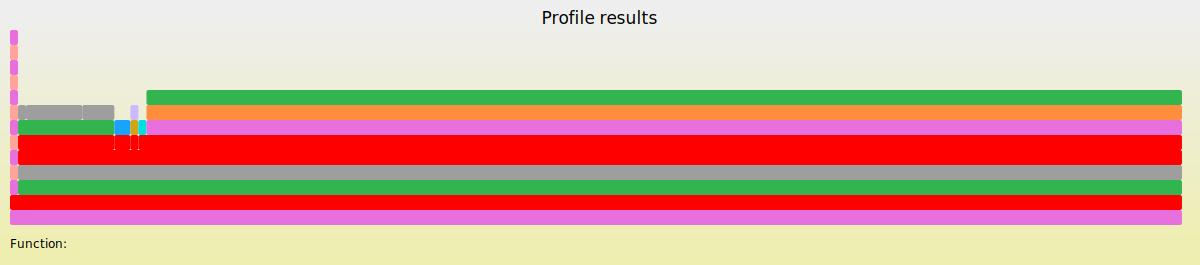

In [57]:
ProfileView.view()